In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import transpile
from qiskit.providers.basic_provider import BasicSimulator

## Практична робота №1 (частина 2)

У даному прикладі реалізовано full adder для довільної кількості бітів за наступною схемою:

![Full adder](./data/full_adder.png)

Одразу попереджу, що є певне обмеження на кількість бітів для обчислення додавання. Максимум qiskit приймає 7 числа, на 8 і більше починають з'являтися помилки.

До практичної роботи додам корисні посилання, що допомогли розібратися:
1) [туторіал по quiskit](https://arxiv.org/pdf/1903.04359)
2) [вікіпедія про додавання](https://en.wikipedia.org/wiki/Adder_(electronics))
3) [трошки туторіалу від quiskit](https://www.youtube.com/watch?v=oaAjxcIFLtM&list=PLOFEBzvs-VvrgHZt3exM_NNiNKtZlHvZi)
4) [приклади](https://github.com/SaraM92/Intro-to-QC/blob/master/Intro%20to%20QC-oct2020.ipynb)
5) [приклади 2](https://github.com/Qiskit/qiskit/blob/main/examples/python/rippleadd.py)

In [5]:
def fill_register(qc: QuantumCircuit, a: QuantumRegister, num, n):
    for i in range(n):
        if (num >> i) & 1 == 1:
            qc.x(a[i])


def full_add(circuit, c_0, a_0, b_0, c_1):
    """Full add gate."""
    circuit.ccx(a_0, b_0, c_1)
    circuit.cx(a_0, b_0)
    circuit.ccx(b_0, c_0, c_1)
    circuit.cx(b_0, c_0)
    circuit.cx(a_0, b_0)

n: 7
{'01000111': 1024}


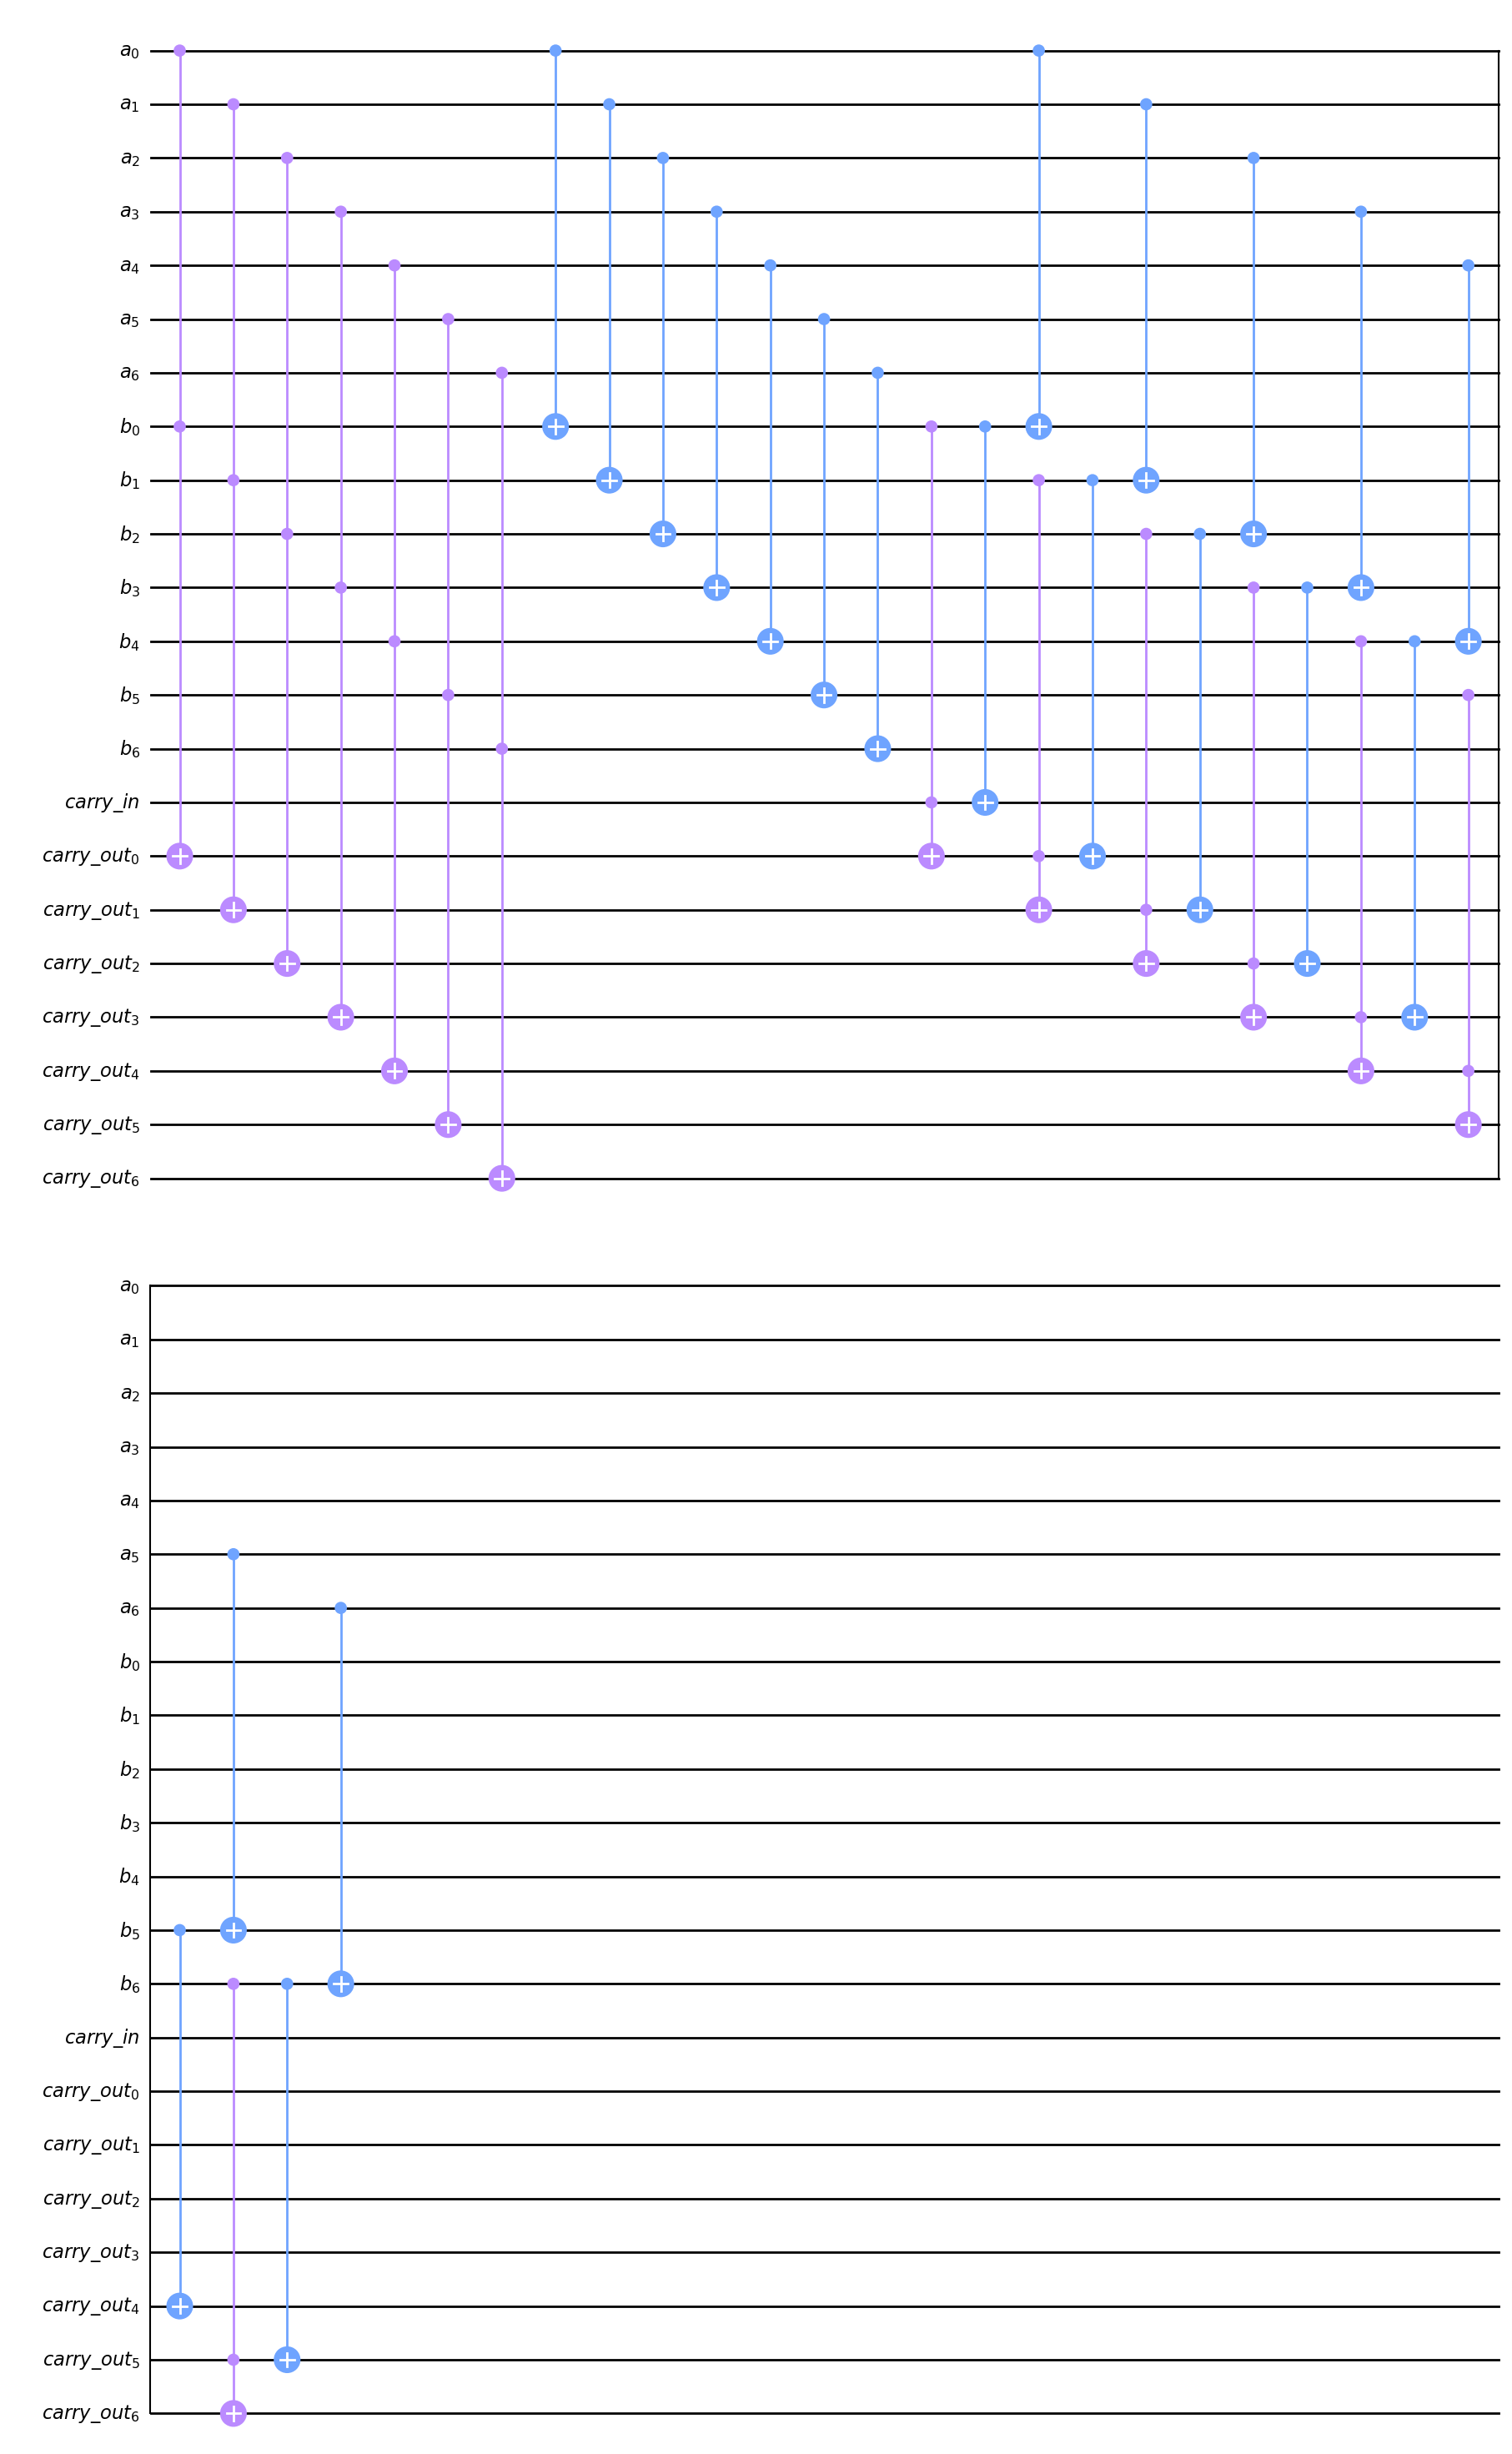

In [6]:
# MAX 7 BITS !!!
A = 0b111
B = 0b1000000
# Number of bits to be added
n = A.bit_length() if A.bit_length() > B.bit_length() else B.bit_length()
print("n: {0}".format(n))

backend = BasicSimulator()
a = QuantumRegister(n, "a")
b = QuantumRegister(n, "b")
carry_in = QuantumRegister(1, "carry_in")
carry_out = QuantumRegister(n, "carry_out")
answer = ClassicalRegister(n + 1, "answer")
qc = QuantumCircuit(a, b, carry_in, carry_out, answer, name="fulladd")

# Build a temporary subcircuit that adds a to b,
adder_subcircuit = QuantumCircuit(a, b, carry_in, carry_out)
full_add(adder_subcircuit, carry_in[0], a[0], b[0], carry_out[0])
for i in range(1, n):
    full_add(adder_subcircuit, carry_out[i - 1], a[i], b[i], carry_out[i])

# Fill inputs
fill_register(qc, a, A, n)
fill_register(qc, b, B, n)

# Add numbers
qc &= adder_subcircuit
# Measure the output register in the computational basis
qc.measure(carry_in[0], answer[0])
for j in range(0, n):
    qc.measure(carry_out[j], answer[j + 1])

# Measure output with shots
job = backend.run(transpile(qc, backend=backend, coupling_map=None), shots=1024)
result = job.result()
print(result.get_counts(qc))

adder_subcircuit.draw(output="mpl", style="clifford")